In [180]:
import pandas as pd
import numpy as np
from collections import defaultdict
import csv
import nltk
from matplotlib import pyplot as plt
import os
import re
import warnings
import random
warnings.filterwarnings('ignore')
from collections import Counter,defaultdict
from nltk import word_tokenize
from math import log
import string
import pickle
from math import log
import gensim
from gensim import corpora
from gensim import models
from string import digits
from collections import defaultdict
from scipy.spatial.distance import cosine
import ast
cwd = os.getcwd()

In [2]:
osname = os.name
if osname =='Windows':
    sym = "//"
else:
    sym = "/"

In [3]:
r_path=cwd+sym+'nips_reviewer_data'+sym+'reviewers.txt'
review_df=pd.read_csv(r_path,sep='\t',header=None)
review_df.columns=['sno','name']
review_lt=list(review_df.name)
review_sno={val:ind for ind,val in enumerate(review_lt)}

## Loading Necessary files

In [393]:
path1=cwd+sym+'Saved_Items'+sym
with open(path1+'dictionary.pkl','rb') as f:
    dictionary=pickle.load(f)
with open(path1+'tfidf.pkl','rb') as f:
    tfidf=pickle.load(f)
with open(path1+'ldaModel250','rb') as f:
    lda_model=pickle.load(f)
with open(path1+'cocit.pkl','rb') as f:
    cocit_mat=pickle.load(f)
with open(path1+'bibcoupling.pkl','rb') as f:
    bc_mat=pickle.load(f)
with open(path1+'distance.pkl','rb') as f:
    dist=pickle.load(f)
with open(path1+'paper_vec2.pkl','rb') as f:
    paper_vec2=pickle.load(f)
with open(path1+'paper_id.pkl','rb') as f:
    paper_id=pickle.load(f)
with open(path1+'reviewer_vec.pkl','rb') as f:
    reviewer_vec=pickle.load(f)
with open(path1+'topic_community.pkl','rb') as f:
    topic_comm=pickle.load(f)
with open(path1+'paper_auth.pkl','rb') as f:
    paper_auth=pickle.load(f)
with open(path1+'reviewer_matrix.pkl','rb') as f:
    reviewer_matrix=pickle.load(f)
with open(path1+'reviewer_vec_bow.pkl','rb') as f:
    reviewer_vec_bow=pickle.load(f)
reviewer_detail=pd.read_pickle(path1+'auth_detail.pkl')

In [543]:
with open(path1+'reviewer_matrix_temp.pkl','rb') as f:
    reviewer_matrix=pickle.load(f)

## New Paper's Title and Abstract

In [5]:
title='Learning from Multiple Sources'
abstract='''
Categorization is a central activity of human cognition. When an individual is asked to categorize a sequence of items, context effects arise: categorization of one item influences category decisions for subsequent items. Specifically, when experimental subjects are shown an exemplar of some target category, the category prototype appears to be pulled toward the exemplar, and the prototypes of all nontarget categories appear to be pushed away. These push and pull effects diminish with experience, and likely reflect long-term learning of category boundaries. We propose and evaluate four principled probabilistic (Bayesian) accounts of context effects in categorization. In all four accounts, the probability of an exemplar given a category is encoded as a Gaussian density in feature space, and categorization involves computing category posteriors given an exemplar. The models differ in how the uncertainty distribution of category prototypes is represented (localist or distributed), and how it is updated following each experience (using a maximum likelihood gradient ascent, or a Kalman filter update). We find that the distributed maximum-likelihood model can explain the key experimental phenomena. Further, the model predicts other phenomena that were confirmed via reanalysis of the experimental data. Categorization is a central activity of human cognition. We continually make decisions about characteristics of objects and individuals: Is the fruit ripe? Does your friend seem unhappy? Is your car tire flat? Should this manuscript be accepted for publication in NIPS? When an individual is asked to categorize a sequence of items, context effects arise: categorization of one item influences category decisions for subsequent items. Intuitive naturalistic scenarios in which context effects occur are easy to imagine. For example, if one lifts a medium-weight object after lifting a light-weight or heavy-weight object, the medium weight feels heavier following the light weight than following the heavy weight. Although the object-contrast effect might be due to fatigue of sensory-motor systems, many context effects in categorization are purely cognitive and cannot easily be attributed to neural habituation. For example, if you are reviewing a set of conference papers, and the first three in the set are dreadful, then even a mediocre paper seems like it might be above threshold for acceptance. Another example of a category boundary shift due to context is the following. Suppose you move from San Diego to Pittsburgh and notice that your neighbors repeatedly describe muggy, somewhat overcast days as Ólovely.Ó Eventually, your notion of what constitutes a lovely day accommodates to your new surroundings. As we describe shortly, experimental studies have shown a fundamental link between context effects in categorization and long-term learning of category boundaries. We believe that context effects can be viewed as a reflection of a trial-to-trial learning, and the cumulative effect of these trial-to-trial modulations corresponds to what we classically consider to be category learning. Consequently, any compelling model of category learning should also be capable of explaining context effects. stimulus dimension ABCD example Figure 1: Schematic depiction of sequential effects in categorization 
'''
text=title+abstract

## PreProcessing

In [6]:
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
st = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer 
import re

def cleantext(text):
    
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    
    # remove punctuation
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    strip = text.translate(table)
    
    
    # Tokenizer
    tokens = word_tokenize(strip)
    
    # Convert into lower case 
    proc_text = [w.lower() for w in tokens]
    
    # Remove stopwords
    proc_text = [word for word in proc_text if word not in st]
    
    
    #Storing only Lemmmatized words
    lemmatizer=WordNetLemmatizer()
    lemma_text=[lemmatizer.lemmatize(word) for word in proc_text]

    return " ".join(lemma_text)


t = "i am groot2'7"    
cleantext(t)

'groot'

In [7]:
def get_column_slice(array_or_dataframe,coloumn):
    return np.asarray(array_or_dataframe)[:, coloumn]

In [8]:
num_topics=250

## Consolidated Functions 

In [9]:
def topic_level(text):
    # Loading saved Lda model,dictionary,tfidf vectorizer
    
    clean_text=list(word_tokenize(cleantext(text))) 
    bow_text=dictionary.doc2bow(clean_text)
    tfidf_text=tfidf[bow_text]
    topic=lda_model[tfidf_text]

    topic_vec=np.zeros(num_topics)
    for ind,wt in topic:
        topic_vec[ind]=wt
    
    # Topic of interest and community
    
    no_top_topic=5
    toi=[]#topic of interest
    if len(topic)<no_top_topic:
        for ind,wt in topic:
            toi.append(ind)
    else:
        topic.sort(key=lambda x:x[1],reverse=True)
        for i in range(no_top_topic):
            toi.append(topic[i][0])

    
    toi_comm=[topic_comm[i] for i in toi]
    toi_comm=set(toi_comm)
    topic_rest=[]
    for index,comm_no in enumerate(topic_comm):
        if comm_no in toi_comm and not index in toi:
            topic_rest.append(index)
    
    return topic_vec,toi,topic_rest

In [10]:
def paper_level(toi,topic_rest):
    poi=[]#papers having maximuim content of toi
    paper_vec_lt=list(paper_vec2.values())
    for i in toi:
        samp=get_column_slice(paper_vec_lt,i)
        ind=np.argmax(np.array(samp))
        poi.append(ind)
    puc=[]#papers under consideration
    for i in topic_rest:
        topic_paper=get_column_slice(paper_vec_lt,i)
        n1=len(np.where(topic_paper>0)[0])
        thres=sum(topic_paper)/n1
        ind_list=np.where(topic_paper>thres)[0]
        for ele in ind_list:
            puc.append(ele)
    puc=list(set(puc))
    
    paper_scr=[]
    for i in puc:
        num=bc_mat[i]+cocit_mat[i]
        den=min([dist[i][j] for j in poi])
        if den==0:
            scr=float('inf')
        else:
            scr=num/den
        paper_scr.append((scr,i))
    
    scr=[scr for scr,ind in paper_scr]
    paper_scr.sort(reverse=True)
    for i in range(300):
        poi.append(paper_scr[i][1])
    val=np.percentile(scr,75)# taking into acccount only top 25% entries
    potential_paper=[]
    for score,ind in paper_scr:
        if score>val:
            potential_paper.append(ind)
    
    
    return poi,potential_paper


In [110]:
def reviewer_pred(poi,potential_paper,topic_vec,text):
    roi=[]
    ct_roi=[]
    for i in poi:
        roi=roi+paper_auth[i]
    #print(len(set(roi)))
    rest_reviewer=[]
    for i in potential_paper:
        if not paper_auth[i] in roi:
            rest_reviewer=rest_reviewer+paper_auth[i]
    
    
    
    npaper=list(reviewer_detail['pc'])
    citn=list(reviewer_detail['cn'])
    
    clean_text=list(word_tokenize(cleantext(text))) 
    bow_text=dictionary.doc2bow(clean_text)
    tfidf_text=tfidf[bow_text]
    n=len(dictionary)

    bow_vec=np.zeros(n, dtype = float)
    for ind,wt in tfidf_text:
        bow_vec[ind]=wt    
    
    dec_scr=[]
    for i in roi:
        sim=1-cosine(reviewer_vec[i],topic_vec)
        bow_scr=1-cosine(reviewer_vec_bow[i],bow_vec)
        if np.isnan(sim):
            sim=0
        if np.isnan(bow_scr):
            bow_scr=0
        #val=0.1*npaper[i]/max(npaper)+0.1*citn[i]/max(citn)+0.8*sim
        val=0.6*sim+0.4*bow_scr
        #val2=npaper[i]/max(npaper)+citn[i]/max(citn)
        dec_scr.append((val,i))
    dec_scr.sort(reverse=True)
    start_node=dec_scr[0][1]
    
    n=len(review_lt)
    total_node=set([i for i in range(n)])
    invalid_node=total_node-set(roi)-set(rest_reviewer)
    
    custom_matrix=[]
    for i in range(n):
        temp=[]
        for j in range(n):
            temp.append(reviewer_matrix[i][j])
        custom_matrix.append(np.array(temp))
    for node in invalid_node:
        for i in range(n):
            custom_matrix[node][i]=0
            custom_matrix[i][node]=0
    col_sum=[sum(x) for x in zip(*custom_matrix)]

    transition_prob=[]
    for i in range(n):
        op=[]
        for j in range(n):
            if col_sum[j]:
                val=custom_matrix[i][j]/col_sum[j]
            else:
                val=0
            op.append(val)
        transition_prob.append(op)
        
    ini_state=[0]*n
    ini_state[start_node]=1
    len_op=10#No of items to be shown as output
    new_state=ini_state
    for i in range(len_op):
        new_state=np.dot(0.85,np.dot(transition_prob,new_state))+np.dot(0.15,ini_state)
        
    op=new_state.argsort()[-10:][::-1]
    #op=new_state.argsort()[::-1]
    res=[ele+1 for ele in op]
    
    return res
    

In [111]:
def predict(text):
    topic_vec,toi,topic_rest=topic_level(text)
    poi,potential_paper=paper_level(toi,topic_rest)
    pred=reviewer_pred(poi,potential_paper,topic_vec,text)
    
    return pred

## Evaluation

In [13]:
path=path1+'Testing'+sym+'trec_judgments.txt'
ordinal=[]
value=[]
judge={}
with open(path,'r',encoding="utf8")as f:
    for line in f:
        ordinal=list(line.split('\t'))
        value=[int(ordinal[2]),int(ordinal[3][:-1])]
        if int(ordinal[0][4:]) in judge:
            judge[int(ordinal[0][4:])].append(value)
        else :
            judge[int(ordinal[0][4:])]=[value]
            
path=path1+'Testing'+sym+'trec_judgments_additional.txt'
with open(path,'r',encoding="utf8")as f:
    for line in f:
        ordinal=list(line.split('\t'))
        value=[int(ordinal[2]),int(ordinal[3][:-1])]
        if int(ordinal[0]) in judge:
            judge[int(ordinal[0])].append(value)
        else :
            judge[int(ordinal[0])]=[value]


In [14]:
def precision_k(res,gnd_tht,k,paper_no):
    actual=gnd_tht[paper_no]
    actual_auth=[i[0] for i in actual]
    rating=[i[1] for i in actual]
    n=len(actual)
    soft_p=0
    for i in range(k):
        pred=res[i]
        for j in range(n):
            if actual_auth[j]==pred:
                if rating[j]==3:
                    soft_p+=1
                elif rating[j]==2:
                    soft_p+=0.67
                elif rating[j]==1:
                    soft_p+=0.33
                else:
                    break
    soft_p=soft_p/k
    return soft_p

In [17]:
test_abs=pd.read_pickle('test_abs')
n=len(test_abs)
ctr=0
avg_precision=[0]*11
valid_file=list(judge.keys())
for i in range(n):
    if i in valid_file:        
        res=predict(test_abs['abstract'].iloc[i])
        #print(res)
        for k in range(1,11):
            avg_precision[k]+=precision_k(res,judge,k,i)
        ctr+=1
avg_precision=[ele/ctr for ele in avg_precision]

In [18]:
avg_precision[1:]

[0.3332352941176471,
 0.396764705882353,
 0.316764705882353,
 0.2669852941176471,
 0.27041176470588235,
 0.2547549019607844,
 0.24357142857142863,
 0.23025735294117644,
 0.22098039215686271,
 0.2194705882352941]

## Handling Reviewers not present in Ground Thruth

In [42]:
def reviewer_404(res,ground_tht,paper_no):
    actual=ground_tht[paper_no]
    actual_auth=[i[0] for i in actual]
    rating=[i[1] for i in actual]
    n=len(actual)
    output=[]
    for auth in res:
        if auth not in actual_auth:
            sim_scr=[0]*4
            count=[0]*4
            vec1=reviewer_vec_bow[auth-1]
            for i in range(n):
                val=1-cosine(vec1,reviewer_vec_bow[actual_auth[i]-1])
                if np.isnan(val):
                    val=0
                sim_scr[rating[i]]+=val
                count[rating[i]]+=1
            sim_scr=[sim_scr[i]/count[i] for i in range(4) if count[i]]
            max_scr=max(sim_scr)
            ind=sim_scr.index(max_scr)

            output.append([auth,ind])
            #print(sim_scr)
    return output
                
    
    
    

In [33]:
res1=predict(test_abs['abstract'].iloc[0])
op=reviewer_404(res1,judge,0)

In [34]:
op

[[162, 3], [234, 2], [23, 3], [12, 0], [164, 0]]

In [536]:
def precision_k_404(res,gnd_tht,k,paper_no):
    actual=gnd_tht[paper_no]
    actual_auth=[i[0] for i in actual]
    rating=[i[1] for i in actual]
    n=len(actual)
    soft_p=0
    for i in range(k):
        pred=res[i]
        for j in range(n):
            if actual_auth[j]==pred:
                if rating[j]==3:
                    soft_p+=1
                elif rating[j]==2:
                    soft_p+=1
                elif rating[j]==1:
                    soft_p+=0
                else:
                    break
    rating_gen=reviewer_404(res,gnd_tht,paper_no)
    auth_gen=[i[0] for i in rating_gen]
    rating_gen=[i[1] for i in rating_gen]
    n1=len(auth_gen)
    for i in range(k):
        pred=res[i]
        for j in range(n1):
            if auth_gen[j]==pred:
                if rating_gen[j]==3:
                    soft_p+=1
                elif rating_gen[j]==2:
                    soft_p+=1
                elif rating_gen[j]==1:
                    soft_p+=0
                else:
                    break
    soft_p=soft_p/k
    return soft_p

In [544]:
test_abs=pd.read_pickle('test_abs')
n=len(test_abs)
ctr=0
avg_precision=[0]*11
valid_file=list(judge.keys())
for i in range(n):
    if i in valid_file:        
        res=predict(test_abs['abstract'].iloc[i])
        #print(res)
        for k in range(1,11):
            avg_precision[k]+=precision_k_404(res,judge,k,i)
        ctr+=1
avg_precision=[ele/ctr for ele in avg_precision]

In [545]:
avg_precision[1:]

[0.5588235294117647,
 0.5,
 0.5490196078431372,
 0.5514705882352942,
 0.5470588235294118,
 0.5441176470588236,
 0.5504201680672269,
 0.5551470588235294,
 0.5522875816993464,
 0.5588235294117647]

### Insight about our results

In [20]:
def gndtht_stats(res,gnd_tht,paper_no):
    actual=gnd_tht[paper_no]
    actual_auth=[i[0] for i in actual]
    rating=[i[1] for i in actual]
    ctr_3=0
    ctr_2=0
    ctr_1=0
    ctr_0=0
    ctr_not=0    
    for ele in res:
        if ele in actual_auth:
            ind=actual_auth.index(ele)
            if rating[ind]==3:
                ctr_3+=1
            elif rating[ind]==2:
                ctr_2+=1
            elif rating[ind]==1:
                ctr_1+=1
            else:
                ctr_0+=1
        else:
            ctr_not+=1
    return ctr_3,ctr_2,ctr_1,ctr_0,ctr_not

In [21]:
test_abs=pd.read_pickle('test_abs')
n=len(test_abs)
ctr=0
avg_precision=[0]*11
valid_file=list(judge.keys())
op=[]
for i in range(n):
    if i in valid_file:        
        res=predict(test_abs['abstract'].iloc[i])
        #print(res)
        res1=gndtht_stats(res,judge,i)
        op.append([i,res1])

In [22]:
for entry in op:
    file_id=entry[0]
    stats=entry[1]
    label=['No of judgement with rel 3:','No of judgement with rel 2:','No of judgement with rel 1:','No of judgement with rel 0:','No of judgement not in ground thruth:']
    print('File Id:',file_id)
    for i in range(5):
        print(label[i],stats[i])
    print('######################################')

File Id: 0
No of judgement with rel 3: 2
No of judgement with rel 2: 0
No of judgement with rel 1: 3
No of judgement with rel 0: 0
No of judgement not in ground thruth: 5
######################################
File Id: 1
No of judgement with rel 3: 0
No of judgement with rel 2: 4
No of judgement with rel 1: 1
No of judgement with rel 0: 1
No of judgement not in ground thruth: 4
######################################
File Id: 2
No of judgement with rel 3: 0
No of judgement with rel 2: 1
No of judgement with rel 1: 2
No of judgement with rel 0: 2
No of judgement not in ground thruth: 5
######################################
File Id: 3
No of judgement with rel 3: 1
No of judgement with rel 2: 0
No of judgement with rel 1: 0
No of judgement with rel 0: 3
No of judgement not in ground thruth: 6
######################################
File Id: 4
No of judgement with rel 3: 0
No of judgement with rel 2: 2
No of judgement with rel 1: 0
No of judgement with rel 0: 1
No of judgement not in ground

## Expertise Metric

In [336]:
def expertise(res,k,query):
    clean_text=list(word_tokenize(cleantext(query))) 
    bow_text=dictionary.doc2bow(clean_text)
    tfidf_text=tfidf[bow_text]
    topic=lda_model[tfidf_text]

    topic_vec=np.zeros(num_topics)
    for ind,wt in topic:
        topic_vec[ind]=wt
    
    expert_scr=0
    for i in range(k):
        temp_scr=1-cosine(topic_vec,reviewer_vec[res[i]-1])
        if np.isnan(temp_scr):
            temp_scr=0
        expert_scr+=temp_scr
    
    expert_scr=expert_scr/k
    
    return expert_scr
    

In [337]:
test_abs=pd.read_pickle('test_abs')
n=len(test_abs)
ctr=0
expertise_k=[0]*11
valid_file=list(judge.keys())
for i in range(n):
    if i in valid_file:        
        res=predict(test_abs['abstract'].iloc[i])
        #print(res)
        for k in range(1,11):
            expertise_k[k]+=expertise(res,k,test_abs['abstract'].iloc[i])
        ctr+=1
avg_expertise_k=[ele/ctr for ele in expertise_k]

In [338]:
avg_expertise_k[1:]

[0.7668277469595643,
 0.7212900274873323,
 0.7128708883252811,
 0.6981370907646861,
 0.6881152635070239,
 0.6897492248827924,
 0.6846105824308703,
 0.6793597162338412,
 0.6770969799301807,
 0.6828991189643149]

In [549]:
from sklearn.metrics import jaccard_similarity_score
a=[0,0,0,1]
b=[1,0,0,1]
jaccard_similarity_score(a,b)  

0.75

## Authority Metrics

In [339]:
path1=cwd+sym+'Saved_Items'+sym
hind=pd.read_csv(path1+'hIndex.txt',header=None)
hind=list(hind[0])

def authority_k(res,k):
    authority=0
    for i in range(k):
        authority+=hind[res[i]-1]
    authority=authority/k
    return authority
    
    

In [340]:
test_abs=pd.read_pickle('test_abs')
n=len(test_abs)
ctr=0
authority_k_net=[0]*11
valid_file=list(judge.keys())
for i in range(n):
    if i in valid_file:        
        res=predict(test_abs['abstract'].iloc[i])
        #print(res)
        for k in range(1,11):
            authority_k_net[k]+=authority_k(res,k)
        ctr+=1
authority_k_res=[ele/ctr for ele in authority_k_net]

In [341]:
authority_k_res[1:]

[21.88235294117647,
 38.661764705882355,
 37.2156862745098,
 37.080882352941174,
 37.23529411764706,
 37.50490196078431,
 37.7142857142857,
 37.23529411764706,
 36.98366013071895,
 37.247058823529414]

## Diversity Metrics

In [473]:
def KL(p,q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001
    
    # You may want to instead make copies to avoid changing the np arrays.
    vec1=reviewer_vec[p-1]
    vec2=reviewer_vec[q-1]
    
    vec1=np.array(vec1)
    v1sum=np.sum(vec1)
    vec2=np.array(vec2)
    v2sum=np.sum(vec2)

    vec1=np.divide(vec1,v1sum)
    vec2=np.divide(vec2,v2sum)
        
    vec1 = vec1+epsilon
    vec2 = vec2+epsilon
    
    if v1sum==0 or v2sum==0:
        return 0

    divergence = np.sum(vec1*np.log10(vec1/vec2))
    return divergence

def diversity(res):
    div=0
    n=len(res)
    for i in range(n):
        for j in range(n):
            div+=KL(res[i],res[j])
    div=div/(n*(n-1))
    return div
    

In [343]:
test_abs=pd.read_pickle('test_abs')
n=len(test_abs)
ctr=0
diverse=0
valid_file=list(judge.keys())
for i in range(n):
    if i in valid_file:        
        res=predict(test_abs['abstract'].iloc[i])
        diverse+=diversity(res)
        ctr+=1
diverse=diverse/ctr

In [344]:
diverse

0.4415717476301809

## Alternative Diversity Metrics

In [432]:
from sklearn.metrics.pairwise import cosine_similarity
def diversity(res):
    div=0
    n=len(res)
    for i in range(n):
        for j in range(n):
            sim=cosine_similarity([reviewer_vec[res[i]-1],reviewer_vec[res[j]-1]])
            sim=sim[0][1]
            div+=1-sim
    div=div/(n*(n-1))
    return div
    

In [388]:
test_abs=pd.read_pickle('test_abs')
n=len(test_abs)
ctr=0
diverse=0
valid_file=list(judge.keys())
for i in range(n):
    if i in valid_file:        
        res=predict(test_abs['abstract'].iloc[i])
        diverse+=diversity(res)
        ctr+=1
diverse=diverse/ctr

In [389]:
diverse

0.2998115047827517

## Language model

In [120]:
with open(path1+'reviewer_text.pkl','rb') as f:
    reviewer_text=pickle.load(f)

In [158]:
sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)

In [193]:
text_set=list(reviewer_text.values())
docs=list(map(cleantext,text_set))
tokenize_doc=[list(word_tokenize(doc)) for doc in docs]
corpus=' '.join(docs)

In [196]:
from nltk.util import ngrams
bigram_doc=[]
for doc in tokenize_doc:
    c=Counter(ngrams(doc,2))
    bigram_doc.append(c)

In [194]:
tokenize_corpus=list(word_tokenize(corpus))
bigram_corpus=Counter(ngrams(tokenize_corpus,2))

In [277]:
corpus_size=len(tokenize_corpus)
def predict_lm(bigram_corpus,bigram_doc,query,tokenize_doc):
    prob_score=[]
    token_list=list(word_tokenize(query))
    bigram_query=Counter(ngrams(token_list,2))
    mu=2000 #Dirchlet smoothing Parameter
    for ind,doc in enumerate(bigram_doc):
        nd=len(tokenize_doc[ind])
        scr=1
        for bigram in bigram_query.keys():
            if bigram in doc:
                prob_doc=doc[bigram]/(nd-1)
                prob_net=bigram_corpus[bigram]/(corpus_size-1)
            else:
                prob_doc=0
                if bigram in bigram_corpus:
                    prob_net=bigram_corpus[bigram]/(corpus_size-1)
                else:
                    prob_net=1/(2*corpus_size-1)               
            scr=scr*(((nd*prob_doc)/(nd+mu))+(mu*prob_net)/(nd+mu))
        prob_score.append(scr)
    
    prob_score=np.array(prob_score)
    val=prob_score.argsort()[-10:][::-1]
    #op=new_state.argsort()[::-1]
    res=[ele+1 for ele in val]
    
    return res
    

In [276]:
res=predict_lm(bigram_corpus,bigram_doc,test_abs['abstract'].iloc[i],tokenize_doc)

0

In [417]:
test_abs=pd.read_pickle('test_abs')
n=len(test_abs)
ctr=0
avg_precision=[0]*11
valid_file=list(judge.keys())
for i in range(n):
    if i in valid_file:        
        res=res=predict_lm(bigram_corpus,bigram_doc,test_abs['abstract'].iloc[i],tokenize_doc)
        #print(res)
        for k in range(1,11):
            avg_precision[k]+=precision_k_404(res,judge,k,i)
        ctr+=1
avg_precision=[ele/ctr for ele in avg_precision]

## Diversity vs Precision

In [424]:
def reviewer_label(res,gnd_tht,paper_no):
    actual=gnd_tht[paper_no]
    actual_auth=[i[0] for i in actual]
    rating=[i[1] for i in actual]
    n=len(actual)
    soft_p=0
    n1=len(res)
    output=[]
    
    for i in range(n1):
        pred=res[i]
        for j in range(n):
            if actual_auth[j]==pred:
                if rating[j]==3:
                    output.append((pred,3))
                elif rating[j]==2:
                    output.append((pred,2))
                elif rating[j]==1:
                    output.append((pred,1))
                else:
                    output.append((pred,0))
                    break
    rating_gen=reviewer_404(res,gnd_tht,paper_no)
    auth_gen=[i[0] for i in rating_gen]
    rating_gen=[i[1] for i in rating_gen]
    n1=len(auth_gen)
    for i in range(k):
        pred=res[i]
        for j in range(n1):
            if auth_gen[j]==pred:
                if rating_gen[j]==3:
                    output.append((pred,3))
                elif rating_gen[j]==2:
                    output.append((pred,2))
                elif rating_gen[j]==1:
                    output.append((pred,1))
                else:
                    output.append((pred,0))
                    break
    
    return output

In [425]:
test_abs=pd.read_pickle('test_abs')
n=len(test_abs)
ctr=0
avg_precision=[0]*11
valid_file=list(judge.keys())
reviewer_rel=[]
for i in range(n):
    if i in valid_file:        
        res=predict(test_abs['abstract'].iloc[i])
        paper_reviewer_rel=reviewer_label(res,judge,i)
        reviewer_rel=reviewer_rel+paper_reviewer_rel


In [428]:
import random

In [429]:
random.sample(reviewer_rel,5)

[(164, 2), (234, 3), (295, 1), (164, 2), (214, 0)]

In [430]:
reviewer_rel

[(183, 3),
 (9, 3),
 (53, 1),
 (108, 1),
 (34, 1),
 (162, 3),
 (234, 2),
 (23, 3),
 (12, 0),
 (164, 0),
 (9, 1),
 (162, 2),
 (53, 0),
 (34, 2),
 (108, 2),
 (211, 2),
 (174, 2),
 (23, 2),
 (234, 2),
 (12, 3),
 (225, 1),
 (9, 0),
 (34, 0),
 (108, 1),
 (295, 2),
 (12, 2),
 (162, 2),
 (234, 2),
 (53, 2),
 (164, 2),
 (270, 0),
 (9, 0),
 (295, 3),
 (34, 0),
 (162, 1),
 (234, 1),
 (108, 1),
 (211, 1),
 (164, 1),
 (12, 1),
 (213, 0),
 (9, 2),
 (10, 2),
 (162, 2),
 (234, 2),
 (108, 2),
 (106, 1),
 (145, 2),
 (164, 2),
 (53, 2),
 (218, 3),
 (9, 1),
 (108, 3),
 (34, 0),
 (234, 1),
 (162, 1),
 (164, 1),
 (53, 1),
 (106, 1),
 (12, 1),
 (214, 0),
 (9, 3),
 (108, 1),
 (211, 1),
 (228, 0),
 (34, 0),
 (234, 3),
 (162, 1),
 (164, 1),
 (23, 3),
 (9, 2),
 (162, 3),
 (34, 1),
 (53, 3),
 (197, 3),
 (234, 3),
 (108, 3),
 (211, 3),
 (23, 3),
 (164, 3),
 (78, 1),
 (9, 3),
 (108, 3),
 (12, 2),
 (34, 3),
 (295, 2),
 (162, 3),
 (234, 3),
 (53, 3),
 (164, 3),
 (295, 1),
 (162, 0),
 (34, 0),
 (203, 0),
 (309, 0),
 

In [516]:
bins=[[] for i in range(5)]#Range 0-0.2,0.2-0.4,so on
min_entry=15
#Upper Bound inclusive 

In [517]:
for i in range(5):
    min_lim=0.2*i
    max_lim=0.2*(i+1)
    entry=0
    while(entry<min_entry):
        small_set=random.sample(reviewer_rel,5)
        n=len(small_set)
        prec_set=[tupule[1] for tupule in small_set]
        review_set=[tupule[0] for tupule in small_set]
        prec=sum(prec_set)/(len(prec_set)*3)
        div=diversity(review_set)
        if div>min_lim and div<=max_lim:
            entry+=1
            bins[i].append((prec,div))
            
   

        

In [518]:
prec_set=[]
div_set=[]
for i in range(5):
    samp=[entry[0] for entry in bins[i]]
    prec=sum(samp)/min_entry
    prec_set.append(prec)
    div=0.1+0.2*i
    div_set.append(div)

Text(0, 0.5, 'Precision')

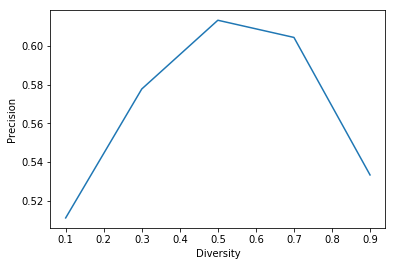

In [519]:
plt.plot(div_set,prec_set) 
plt.xlabel('Diversity') 
plt.ylabel('Precision') 


In [521]:
prec_set

[0.5111111111111112,
 0.5777777777777778,
 0.6133333333333333,
 0.6044444444444443,
 0.5333333333333333]